   #  1. Data Preparation

## Preparing Environement

In [4]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import find_dotenv, load_dotenv
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(), os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

from visualization import visualize as vis
%aimport helpers
%aimport visualization.visualize

from external import kMedoids
from data.preprocessing import *
%aimport data.preprocessing
from IPython.display import display


#Load env vars
load_dotenv(find_dotenv())

#printing
pd.options.display.float_format = '{:,.2f}'.format


## Loading raw data

In [6]:
subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

row_headers = ['Product','Client']
row_headers = ['Product']
n_row_headers = len(row_headers)

file_name = "7S_HistPerProduct_p2_jour.csv"


df_HistPerProduct_p2c4 = pd.read_csv(interim_path + file_name , sep = ";", encoding = 'utf-8', header = 0)
product_raw_df = df_HistPerProduct_p2c4

cols = product_raw_df.columns.values
cols[:n_row_headers]  = row_headers
product_raw_df.columns =cols
product_raw_df.set_index(row_headers, inplace=True)

#adding other features
# file_name = "bnd_products_desc.csv"

# product_desc_df = pd.read_csv(raw_path+file_name, sep=';', encoding='iso8859_2')[['Product Group key','Description']]\
#                     .drop_duplicates(subset=['Product Group key'])\
#                     .dropna()
        

#Join with descriptions
# desc_df = product_raw_df.join(product_desc_df.set_index('Product Group key'),on='Product',how='left')[['Product','Description']]\
#                     .fillna("")


print(product_raw_df.shape)
display(product_raw_df.head())


(7037, 211)


,04/01/2015,11/01/2015,18/01/2015,25/01/2015,01/02/2015,08/02/2015,15/02/2015,22/02/2015,01/03/2015,08/03/2015,...,11/11/2018,18/11/2018,25/11/2018,02/12/2018,09/12/2018,16/12/2018,23/12/2018,30/12/2018,06/01/2019,13/01/2019
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30E000400_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30E823101_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30E823102_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30E823103_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [7]:
non_zeros = ~(product_raw_df.fillna(0)==0).all(axis=1)
product_df = product_raw_df.fillna(0).loc[non_zeros].copy()
print(product_df.shape)

(6815, 211)


## Cleaning Series
A series of cleaning functions is applied to raw data in order to get rid of __irrelevant and "dirty" data__ with patterns that could disrupt the model.

Each function has a **threashold** parameter in order to adapt the filtering

### Trimming Zeros from series
Remove empyt data on the two sides

In [8]:
tail = 0
head = 0
#drop first column if zeros
while (product_df.iloc[:,0] == 0).all():
    product_df.drop(product_df.columns[0], axis=1, inplace=True) 
    head +=1
#drop last columns if zeros
while (product_df.iloc[:,-1] == 0).all():
    product_df.drop(product_df.columns[-1], axis=1, inplace=True)
    tail += 1
    
print("The last %d values (complete zeros) of each series have been dropped "%tail)
print("The first %d values (complete zeros) of each series have been dropped "%head)

N, M = product_df.shape
print(N,M)
product_df.head()

The last 55 values (complete zeros) of each series have been dropped 
The first 52 values (complete zeros) of each series have been dropped 
6815 104


,03/01/2016,10/01/2016,17/01/2016,24/01/2016,31/01/2016,07/02/2016,14/02/2016,21/02/2016,28/02/2016,06/03/2016,...,22/10/2017,29/10/2017,05/11/2017,12/11/2017,19/11/2017,26/11/2017,03/12/2017,10/12/2017,17/12/2017,24/12/2017
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30E000400_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,11.00,21.00,43.00,15.00,21.00,20.00,18.00,43.00,21.00,13.00
30E823101_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,90.00,61.00,153.00,59.00,140.00,85.00,82.00,90.00,58.00,68.00
30E823102_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,99.00,66.00,188.00,102.00,181.00,133.00,144.00,158.00,99.00,117.00
30E823103_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,139.00,100.00,267.00,145.00,237.00,167.00,130.00,150.00,130.00,140.00


### Reset series

In [9]:
offset = 1
range_ = 16
centered = np.zeros((N,range_))
i=0
for index,row in product_df.iterrows():
    try:
        f = row.nonzero()[0][0]
        r = np.resize(row[f:f+range_].values,((1,range_)))
        centered[i] = r
        i+=1
    except Exception as error:
        print(index)
        raise error

centered_df = pd.DataFrame(centered,index = product_df.index,columns=range(offset,range_+offset))

centered_df = centered_df.loc[~(centered_df==0).all(axis = 1)]
for i in range(offset)[::-1]:
    centered_df.insert(0,i,0.0)

centered_df.head()

product_sales_raw = centered_df.join(product_raw_df,how="inner")[centered_df.columns[offset:]]
product_sales_raw.head()
save_file(product_sales_raw,"p2_raw",index=True)

In [10]:
product_df = centered_df.copy()
print(product_df.shape)
product_df.head()

(6815, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,
3.6E+101_2,0.00,1.00,7.00,11.00,7.00,5.00,3.00,6.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
30E000400_2,0.00,68.00,392.00,622.00,517.00,469.00,422.00,605.00,423.00,353.00,288.00,211.00,112.00,85.00,56.00,33.00,30.00
30E823101_2,0.00,3.00,22.00,33.00,66.00,48.00,90.00,61.00,153.00,59.00,140.00,85.00,82.00,90.00,58.00,68.00,3.00
30E823102_2,0.00,13.00,53.00,92.00,62.00,99.00,66.00,188.00,102.00,181.00,133.00,144.00,158.00,99.00,117.00,13.00,53.00
30E823103_2,0.00,3.00,26.00,76.00,116.00,72.00,139.00,100.00,267.00,145.00,237.00,167.00,130.00,150.00,130.00,140.00,3.00


### Trailing Zeros: No longer sold
Remove the products that werent sold in the **last 15 weeks**

### Leading Zeros: Recently launched
Remove the products which werent sold in the **25 first weeks**

### Mainly Zeros: Rare sales
Remove the products that werent sold for **at least 5 weeks**

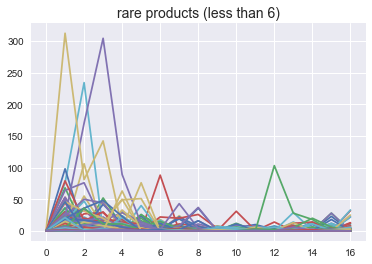

Series With less than 6 values are removed
Removed: 3286 , Remaining: 3529


In [11]:
t = 6

rare =(product_df.where(product_df==0.,other=1.).sum(axis=1)<=t)

for index, row in product_df[rare].iterrows():
    plt.plot(list(row))
plt.title("rare products (less than %d)"%t,size=14)
plt.show()


# product_raw_df.loc[product_df[rare].index,:].to_csv(reports_path+"rare_less_50j.csv",sep=';',encoding='utf-8')

product_df = product_df[~rare]
print("Series With less than %d values are removed"%t)
print("Removed: %d , Remaining: %s"%(rare.astype(int).sum(),product_df.shape[0]))

### Rolling Average

Apply a rolling median filter, then remove rare sales

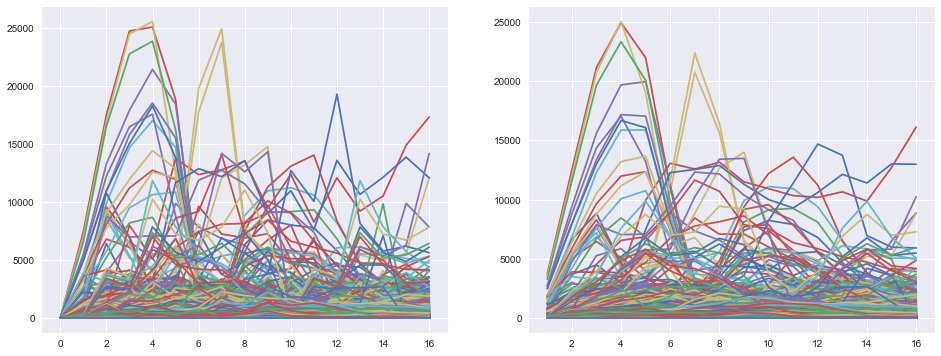

(3529, 16)


In [12]:

window = 2

N = product_df.shape[0]
M = product_df.shape[1]

rolled_df = product_df.rolling(window=window,axis=1,center = True,win_type=None).mean()#shift(window,axis=1)
# rolled_df = rolled_df.rolling(window=window,axis=1,center = False,win_type=None).mean()
s_values = product_df.values
r_values = rolled_df.dropna(axis=1).values

plt.figure(figsize=(16,6))
for i in range(N): 
    plt.subplot(1,2,1)
    plt.plot(np.arange(0,M),s_values[i])
    plt.subplot(1,2,2)
    plt.plot(np.arange(window*1-1,M),r_values[i])
plt.show()
product_df = rolled_df.dropna(axis = 1)

print(product_df.shape)
product_df.head()
N = product_df.shape[0]
M = product_df.shape[1]

In [13]:
product_clean_df = product_df
print(product_clean_df.shape)
product_clean_df.head()

(3529, 16)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
3.6E+101_2,0.50,4.00,9.00,9.00,6.00,4.00,4.50,3.00,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00
30E000400_2,34.00,230.00,507.00,569.50,493.00,445.50,513.50,514.00,388.00,320.50,249.50,161.50,98.50,70.50,44.50,31.50
30E823101_2,1.50,12.50,27.50,49.50,57.00,69.00,75.50,107.00,106.00,99.50,112.50,83.50,86.00,74.00,63.00,35.50
30E823102_2,6.50,33.00,72.50,77.00,80.50,82.50,127.00,145.00,141.50,157.00,138.50,151.00,128.50,108.00,65.00,33.00
30E823103_2,1.50,14.50,51.00,96.00,94.00,105.50,119.50,183.50,206.00,191.00,202.00,148.50,140.00,140.00,135.00,71.50


### Second Rolling median

### Remove Outliers
Use Winsorizing

## Series Decomposition: Trend extraction

## Pre-process Data
We end up with 248 product. Apply a Z-normalization (subtract the mean and divide by the standard deviation)

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = product_df.as_matrix().astype(float)

#stanrdize data 
std_scaler = StandardScaler(with_mean=True, with_std=True).fit(data.T)
X_z = std_scaler.transform(data.T).T
product_df_full = pd.DataFrame(X_z, columns = product_df.columns,index=product_df.index)
print(product_df_full.shape)
product_df_full.head()

(3529, 16)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
3.6E+101_2,-0.66,0.46,2.07,2.07,1.10,0.46,0.62,0.14,-0.82,-0.82,-0.82,-0.82,-0.66,-0.66,-0.82,-0.82
30E000400_2,-1.33,-0.32,1.11,1.43,1.04,0.79,1.14,1.15,0.50,0.15,-0.22,-0.67,-1.00,-1.14,-1.28,-1.34
30E823101_2,-1.97,-1.64,-1.18,-0.51,-0.28,0.08,0.28,1.24,1.21,1.01,1.41,0.53,0.60,0.24,-0.10,-0.94
30E823102_2,-1.97,-1.39,-0.53,-0.43,-0.35,-0.31,0.66,1.06,0.98,1.32,0.92,1.19,0.70,0.25,-0.69,-1.39
30E823103_2,-1.93,-1.72,-1.12,-0.37,-0.41,-0.22,0.01,1.07,1.44,1.19,1.37,0.49,0.35,0.35,0.27,-0.78


## Save Processed data Files

## Version

In [14]:
v = 2

In [15]:
seasons_df = load_file("product_season")
seasons_df.drop(["Key_lvl1"], axis=1, inplace=True)
seasons_df.drop_duplicates(inplace= True)
seasons_df.set_index("Key_lvl2",inplace = True)
seasons = set(seasons_df["Sales Season"])
with_seasons = product_clean_df.join(seasons_df,how="left")


clean_filename = "p2_clean"
save_file(product_clean_df,clean_filename,type_="P",version = v, index=True)

raw_values_filename ="p2_series"
save_file(product_sales_raw.loc[product_clean_df.index],raw_values_filename,type_="P",version=v, index=True)

## Load Season data

In [41]:
X_z = product_df_full.values[:,n_row_headers:]

## Display Cleaned Series

(2259, 13)


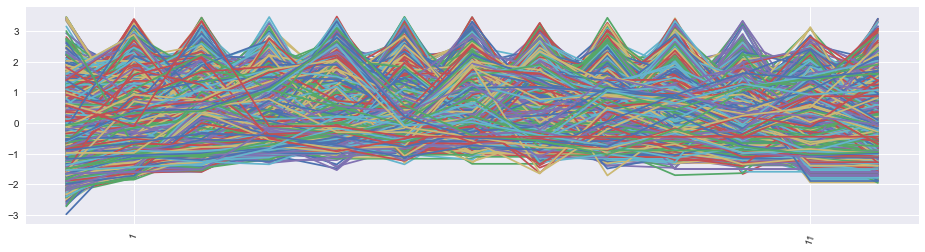

In [43]:
rows = 30
per_row = int(N/rows)+1
row=0
i=1

tf = 10
print(product_df.shape)
plt.figure(figsize=(16,4))

for i,x in enumerate(X_z):
    plt.plot(x)


i+=1
plt.xticks(np.arange(0,M)[1::tf], list(product_df.columns)[1::tf], rotation = 70)

plt.show()

## Model Smoothing
Applying a moving average or an other ARIMA filters to the series

### ARIMA Models

# 2. Principal Components Analysis
Apply a PCA on raw data (standardized), plot the the individual cloud then the correlation circle

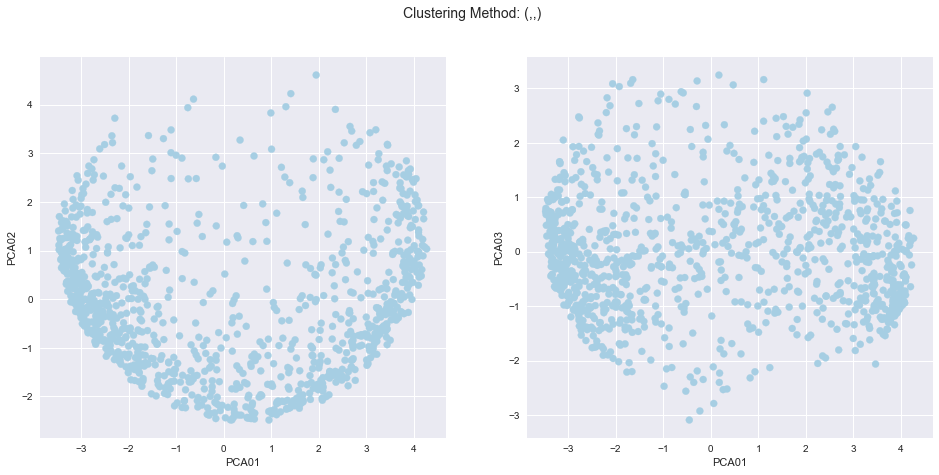

[ 0.50506344  0.16178443  0.09466096  0.05906653  0.04548791]


In [101]:
%matplotlib inline


X = X_z
nb_col=X.shape[1]
pca = PCA(n_components = nb_col)

pca.fit(X)  
princ_axis = pca.components_

X_pca= pca.transform(X)

vis.Clusters_plot(X= X_pca, labels = np.zeros(len(X_pca)))
inertie = pca.explained_variance_ratio_
print(inertie[0:5])
comp = np.transpose(princ_axis)


# vis.circleOfCorrelations(comp,inertie,product_df.columns)
plt.show(block = True)

## PCA 01
It regroups products being sold more over time ie __decreasing trend__ over the last two years

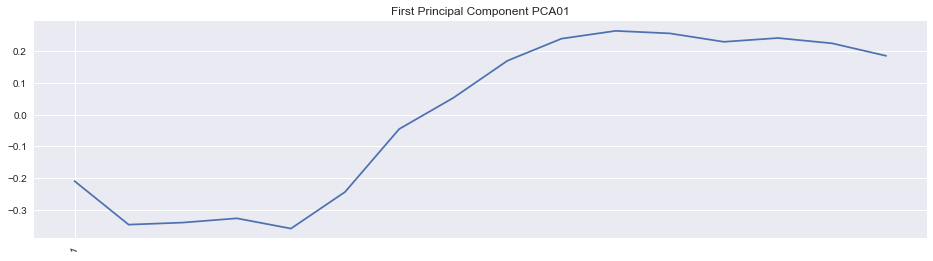

In [102]:
%matplotlib inline

tick_frequency =4 * 7
plt.figure(figsize=(16,4))
plt.title("First Principal Component PCA01")
plt.plot(range(nb_col), princ_axis [0,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 02
Opposes products in term of __sales seasonality__ being sold either in cold or hot seasons

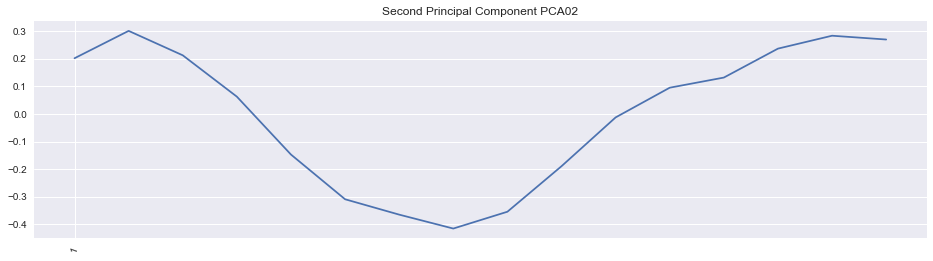

In [103]:
plt.figure(figsize=(16,4))
plt.title("Second Principal Component PCA02")
plt.plot(range(nb_col), princ_axis [1,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 03
The curve seems strongly correlated to __one sales period__. Probably of one product 

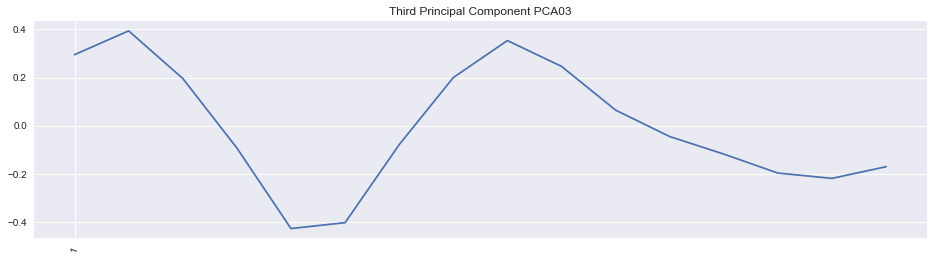

In [104]:
plt.figure(figsize=(16,4))
plt.title("Third Principal Component PCA03")
plt.plot(range(nb_col), princ_axis [2,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 04
The curve seems strongly correlated to __one sales period__. Probably of one product 

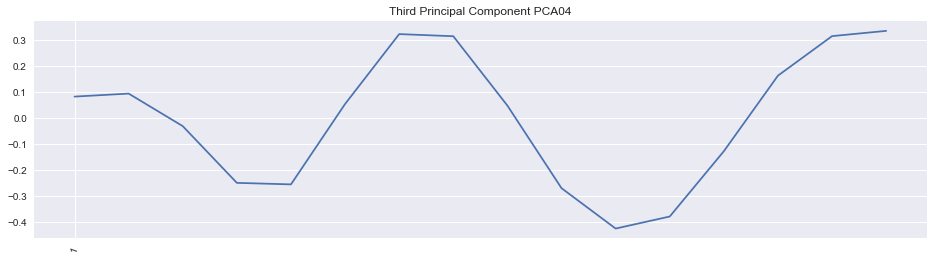

In [105]:
plt.figure(figsize=(16,4))
plt.title("Third Principal Component PCA04")
plt.plot(range(nb_col), princ_axis [3,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

### Plot the samples with the strongest correlation to components
On récupère les examples qui sont le plus corrélés avec un axe principal donné

In [68]:
component = 4
corrSamples = vis.GetMostCorrelatedTo(X_pca,component,index=product_df.index)
corrSamples.head()


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
457,1.98,0.52,0.09,2.47,0.34,1.22,0.10,0.47,0.56,0.45,0.69,0.23,0.98,1.00,0.56,0.00
458,1.55,0.59,0.30,2.45,0.30,1.78,0.12,0.53,0.10,0.21,0.45,0.04,1.02,0.80,0.39,0.00
1000,1.72,0.67,1.37,2.44,0.43,0.57,0.78,0.52,1.73,0.45,0.46,0.92,0.44,0.13,1.04,0.00
132,0.22,2.23,0.24,2.41,2.03,0.31,0.46,0.60,0.71,0.13,1.44,1.20,0.44,0.03,0.39,0.00
168,2.36,0.62,1.05,2.25,1.36,0.69,0.67,0.40,0.01,0.35,0.51,0.72,0.77,0.76,0.32,0.00


### Compare the Most Correlated sample to its principal component
On vérifie si la séquence de l'exemple le plus corrélé suit le schéma de l'axe principal

Produit 457


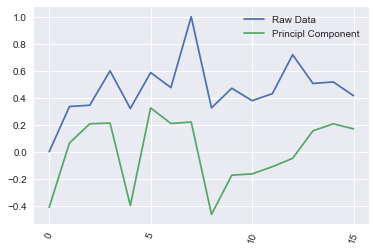

In [61]:
sample = corrSamples.index[0]
print("Produit %d"%sample)
p_axe = princ_axis [component-1,:]
x = product_df.loc[sample]
normalized = (x-min(x))/(max(x)-min(x))

tick_frequency = 5
plt.plot(range(nb_col),normalized, label="Raw Data")
plt.plot(range(nb_col),p_axe , label="Principl Component")
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.legend()
plt.show()